In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

# Añade el path absoluto a la carpeta donde está el archivo
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))

# Importa correctamente el modelo
from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
from torchvision.datasets import EuroSAT

from torchvision import transforms
import os

root_path = "../data"

# Data augmentation y normalización

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño esperado por ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# Descargar el dataset
dataset = EuroSAT(root=root_path, download=True, transform=transform)

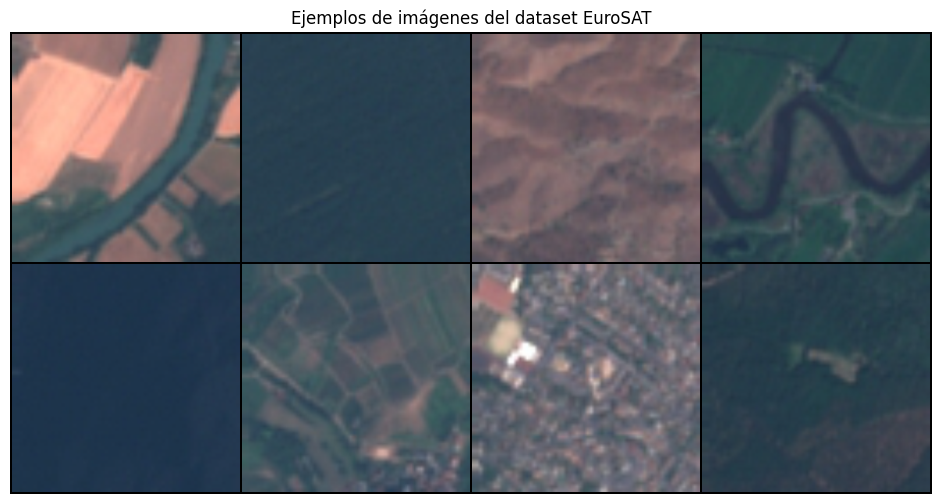

Etiquetas: [8, 1, 2, 8, 9, 6, 7, 1]


In [5]:
# Bloque de visualización (se agrega después del dataset)
import matplotlib.pyplot as plt
import torchvision
import torch
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(loader))

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
images_denorm = images * std + mean

plt.figure(figsize=(12, 6))
grid = torchvision.utils.make_grid(images_denorm, nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Ejemplos de imágenes del dataset EuroSAT')
plt.show()

print("Etiquetas:", labels.tolist())

In [6]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
import torch
import torch.nn as nn
import sys
import os

# === Agregar la ruta absoluta a la carpeta 'backbone' ===
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))

from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

# === Paso 1: preparar argumentos para el backbone ===
class Args:
    image_size = 224
    use_ckpt = "False"

args = Args()

# === Paso 2: crear el backbone ===
backbone = vit_b_rvsa(args, inchannels=3)

# === Paso 3: definir modelo completo (backbone + clasificador) ===
class ModeloClasificacion(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(backbone.out_channels[0], num_classes)

    def forward(self, x):
        features = self.backbone(x)[0]
        pooled = nn.functional.adaptive_avg_pool2d(features, 1).view(x.size(0), -1)
        return self.classifier(pooled)

# === Paso 4: crear el modelo y enviarlo al dispositivo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModeloClasificacion(backbone, num_classes=10).to(device)


/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used


In [26]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
patience = 3

# Early Stopping y listas para guardar métricas
best_val_acc = 0.0
epochs_without_improvement = 0
best_model_path = "mejor_modelo.pth"

train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (i+1) % 10 == 0 or (i+1) == len(train_loader):
            print(f"[{epoch+1}/{num_epochs}] Step {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}", flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    duration = time.time() - start_time

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Época {epoch+1} finalizada | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Tiempo: {duration:.1f}s", flush=True)

    # === Validación ===
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = val_outputs.max(1)
            val_total += val_targets.size(0)
            val_correct += val_predicted.eq(val_targets).sum().item()

    val_acc = 100. * val_correct / val_total
    val_accs.append(val_acc)
    print(f"Validación - Acc: {val_acc:.2f}%\n{'-'*60}", flush=True)

    # === Early stopping ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Nuevo mejor modelo guardado con Acc: {best_val_acc:.2f}%", flush=True)
    else:
        epochs_without_improvement += 1
        print(f"Sin mejora en validación ({epochs_without_improvement}/{patience})", flush=True)
        if epochs_without_improvement >= patience:
            print("Early stopping activado.")
            break

# === Graficar ===
epochs_range = range(1, len(train_losses)+1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Curvas de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [10]:
import torch
import torch.nn as nn
import sys
import os

# === Agregar la ruta absoluta a la carpeta 'backbone' ===
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))

from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

# === Paso 1: preparar argumentos para el backbone ===
class Args:
    image_size = 224
    use_ckpt = "False"

args = Args()

# === Paso 2: crear el backbone ===
backbone = vit_b_rvsa(args, inchannels=3)

# === Paso 3: definir modelo completo (backbone + clasificador MEJORADO) ===
class ClasificadorProfundo(nn.Module):
    """
    Clasificador con pooling mejorado (Avg + Max) y MLP configurable.
    """
    def __init__(self, backbone, num_classes, hidden_dims=[1024, 512], dropout_rate=0.5):
        super().__init__()
        self.backbone = backbone
        
        # ¡IMPORTANTE! El input_dim se duplica porque concatenamos avg y max pooling
        input_dim = backbone.out_channels[0] * 2
        
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h_dim 
            
        layers.append(nn.Linear(input_dim, num_classes))
        
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)[0]
        
        # --- MEJORA EN EL POOLING ---
        # 1. Calcular average pooling
        avg_pool = nn.functional.adaptive_avg_pool2d(features, 1)
        
        # 2. Concatenar los resultados a lo largo de la dimensión de canales (dim=1)
        pooled = torch.cat((avg_pool, max_pool), dim=1)
        # --- FIN DE LA MEJORA ---
        
        # Aplanar el vector resultante para el clasificador
        pooled = pooled.view(x.size(0), -1)
        
        return self.classifier(pooled)


# === Paso 4: crear el modelo y enviarlo al dispositivo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClasificadorProfundo(backbone, num_classes=10).to(device)

The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used


[1/10] Step 10/675 - Loss: 2.2089
[1/10] Step 20/675 - Loss: 1.5245
[1/10] Step 30/675 - Loss: 1.6550
[1/10] Step 40/675 - Loss: 1.9489
[1/10] Step 50/675 - Loss: 1.5046
[1/10] Step 60/675 - Loss: 1.9475
[1/10] Step 70/675 - Loss: 1.5890
[1/10] Step 80/675 - Loss: 1.2918
[1/10] Step 90/675 - Loss: 1.6689
[1/10] Step 100/675 - Loss: 1.5523
[1/10] Step 110/675 - Loss: 1.1496
[1/10] Step 120/675 - Loss: 1.3869
[1/10] Step 130/675 - Loss: 1.5537
[1/10] Step 140/675 - Loss: 1.4381
[1/10] Step 150/675 - Loss: 1.3139
[1/10] Step 160/675 - Loss: 1.3488
[1/10] Step 170/675 - Loss: 1.2414
[1/10] Step 180/675 - Loss: 1.1261
[1/10] Step 190/675 - Loss: 1.0000
[1/10] Step 200/675 - Loss: 1.3678
[1/10] Step 210/675 - Loss: 1.0749
[1/10] Step 220/675 - Loss: 1.2167
[1/10] Step 230/675 - Loss: 1.4498
[1/10] Step 240/675 - Loss: 1.2079
[1/10] Step 250/675 - Loss: 1.2896
[1/10] Step 260/675 - Loss: 0.9870
[1/10] Step 270/675 - Loss: 0.9804
[1/10] Step 280/675 - Loss: 1.1486
[1/10] Step 290/675 - Loss: 1

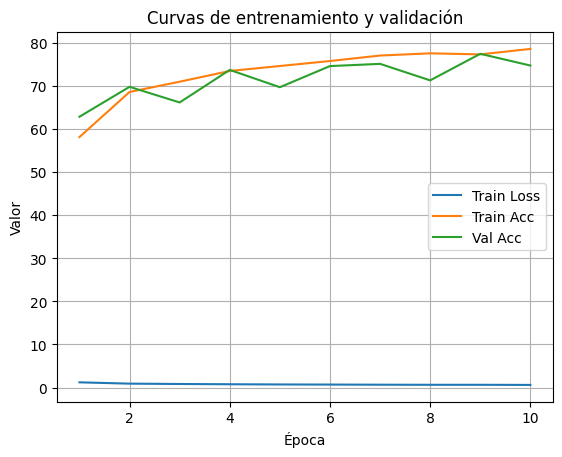

In [9]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-2)
num_epochs = 10
patience = 3

# Early Stopping y listas para guardar métricas
best_val_acc = 0.0
epochs_without_improvement = 0
best_model_path = "mejor_modelo.pth"

train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (i+1) % 10 == 0 or (i+1) == len(train_loader):
            print(f"[{epoch+1}/{num_epochs}] Step {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}", flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    duration = time.time() - start_time

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Época {epoch+1} finalizada | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Tiempo: {duration:.1f}s", flush=True)

    # === Validación ===
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = val_outputs.max(1)
            val_total += val_targets.size(0)
            val_correct += val_predicted.eq(val_targets).sum().item()

    val_acc = 100. * val_correct / val_total
    val_accs.append(val_acc)
    print(f"Validación - Acc: {val_acc:.2f}%\n{'-'*60}", flush=True)

    # === Early stopping ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Nuevo mejor modelo guardado con Acc: {best_val_acc:.2f}%", flush=True)
    else:
        epochs_without_improvement += 1
        print(f"Sin mejora en validación ({epochs_without_improvement}/{patience})", flush=True)
        if epochs_without_improvement >= patience:
            print("Early stopping activado.")
            break

# === Graficar ===
epochs_range = range(1, len(train_losses)+1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Curvas de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()